## Clone and install custom gym

In [0]:
# Clone and install Sigurds version of the gym
!git clone -b master_student_branch https://github.com/sigurdhjerde/gym.git

%cd gym/
!git branch

!ls
!pip install -e .

Cloning into 'gym'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 10081 (delta 0), reused 0 (delta 0), pack-reused 10075
Receiving objects: 100% (10081/10081), 5.15 MiB | 19.48 MiB/s, done.
Resolving deltas: 100% (6875/6875), done.
/content/gym
* master_student_branch
bin		     LICENSE.md		   scripts		  tox.ini
CODE_OF_CONDUCT.rst  Makefile		   setup.py		  unittest.cfg
docs		     README.rst		   test.dockerfile.14.04  vendor
examples	     requirements_dev.txt  test.dockerfile.16.04
gym		     requirements.txt	   test.dockerfile.18.04
Obtaining file:///content/gym
ERROR: stable-baselines 2.2.1 has requirement gym[atari,classic_control]>=0.10.9, but you'll have gym 0.10.8 which is incompatible.
  Found existing installation: gym 0.15.4
    Uninstalling gym-0.15.4:
      Successfully uninstalled gym-0.15.4
  Running setup.py develop for gym


## Import modules

In [0]:
import random
from collections import deque

import gym
import numpy as np

from gym.envs.diabetes.meal_generator.meal_generator import meal_generator

import torch as th
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# **Replay buffer class**

In [0]:
class ReplayBuffer(object):
  def __init__(self, capacity):
    self.buffer = deque(maxlen = capacity)

  def push(self, state, action, reward, next_state, done):
    state      = np.expand_dims(state, 0)
    next_state = np.expand_dims(next_state, 0)

    self.buffer.append((state, action, reward, next_state, done))
  
  def sample(self, batch_size):
    state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
    return np.concatenate(state), action, reward, np.concatenate(next_state), done
  
  def __len__(self):
    return len(self.buffer)

## Initiate environment

In [0]:
env_id = 'HovorkaCambridge-v0'
db = gym.make(env_id)

/content/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Hyperparameters

In [0]:
N_states = db.observation_space.shape[0]
N_actions = db.action_space.n

learning_rate = 1e-3
buffer_size = int(1e4)
batch_size = 128
gamma = 0.99
max_steps = int(1e5)

eps_init  = 1.0
eps_end   = 0.01
eps_decay = 2e4

eps_by_step = lambda t: eps_end + (eps_init - eps_end) * np.exp(-1.*t / eps_decay)

# **Dueling Deep Q Network**

In [0]:
class DuelingDQN(nn.Module):
  def __init__(self, N_states, N_actions):
    super(DuelingDQN, self).__init__()

    self.feature = nn.Sequential(
        nn.Linear(N_states, 64),
        nn.ReLU()
    )

    self.advantage = nn.Sequential(
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, N_actions)
    )

    self.value = nn.Sequential(
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

  def forward(self, x):
    feature   = self.feature(x)
    advantage = self.advantage(feature)
    value     = self.value(feature)

    return value + advantage - advantage.mean()
  
  def choose_action(self, state, epsilon):
    if random.random() > epsilon:
      state  = th.FloatTensor(state).unsqueeze(0)
      q      = self.forward(state)
      action = np.argmax(q.detach().numpy())
    else:
      action = random.randrange(N_actions)
    return action

## Initiate models, optimizer, loss function and replay buffer

In [0]:
model_local   = DuelingDQN(N_states, N_actions)
model_target  = DuelingDQN(N_states, N_actions)
optimizer     = optim.Adam(model_local.parameters(), lr=learning_rate)
loss          = nn.MSELoss()
replay_buffer = ReplayBuffer(buffer_size) 

## Target network update

In [0]:
def update_target(model_local, model_target):
  model_target.load_state_dict(model_local.state_dict())

In [0]:
update_target(model_local, model_target)

# **Learn function**

In [0]:
def learn(batch_size):
  state, action, reward, next_state, done = replay_buffer.sample(batch_size)

  state      = th.FloatTensor(np.float32(state))
  action     = th.LongTensor(action)
  reward     = th.FloatTensor(reward)
  next_state = th.FloatTensor(np.float32(next_state))
  done       = th.FloatTensor(done)

  q_values_current = model_local(state)
  q_values_next    = model_target(next_state)

  Q          = q_values_current.gather(1, action.unsqueeze(1)).squeeze(1)
  Q_next     = q_values_next.max(1)[0]
  Q_expected = reward + gamma * Q_next * (1 - done)

  loss_train = loss(Q, Q_expected.detach())

  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step()

  return loss_train 

# **Train model**

In [0]:
loss_list      = []
reward_list    = []
epsiode_reward = 0
episode_count  = 0

meals, meal_indicator = meal_generator()
db.env.meals          = meals
db.env.meal_indicator = meal_indicator

state = db.reset()

for t in range(1, max_steps + 1):
  epsilon = eps_by_step(t)

  action = model_local.choose_action(state, epsilon)
  next_state, reward, done, _ = db.step(action)
  
  replay_buffer.push(state, action, reward, next_state, done)
  
  state = next_state
  epsiode_reward += reward

  if done:
    meals, meal_indicator = meal_generator()
    db.env.meals          = meals
    db.env.meal_indicator = meal_indicator

    state = db.reset()

    reward_list.append(epsiode_reward)
    epsiode_reward = 0
    episode_count += 1

    if episode_count % 100 == 0:
      print("Episode: {}".format(episode_count))
      print("Time step: {}".format(t))
      print("Mean 100 episode reward: {}".format(np.mean(reward_list[-100:])))
      print("Epsilon: {}".format(epsilon))

  
  if replay_buffer.__len__() > batch_size:
    loss_train = learn(batch_size)
    loss_list.append(loss_train.item())
  
  if t % 100 == 0:
    update_target(model_local, model_target)

Episode: 100
Time step: 7200
Mean 100 episode reward: 34.09274027906691
Epsilon: 0.7006995628103208
Episode: 200
Time step: 14400
Mean 100 episode reward: 33.132306416192435
Epsilon: 0.491884733400372
Episode: 300
Time step: 21600
Mean 100 episode reward: 31.457892432441067
Epsilon: 0.34619957038848975
Episode: 400
Time step: 28800
Mean 100 episode reward: 28.96209930026806
Epsilon: 0.24455848109530054
Episode: 500
Time step: 36000
Mean 100 episode reward: 32.94629573122496
Epsilon: 0.17364589933937066
Episode: 600
Time step: 43200
Mean 100 episode reward: 37.04778987885056
Epsilon: 0.12417186982768189
Episode: 700
Time step: 50347
Mean 100 episode reward: 27.789963174419885
Epsilon: 0.08986637639622283
Episode: 800
Time step: 57448
Mean 100 episode reward: 34.756213315907615
Epsilon: 0.06599738219522377
Episode: 900
Time step: 64603
Mean 100 episode reward: 30.303005883067154
Epsilon: 0.04915604995249427
Episode: 1000
Time step: 71803
Mean 100 episode reward: 21.568403064596687
Epsilo

# Test episode

In [0]:
def test_episode(model):
  done = False
  meals, meal_indicator = meal_generator()
  db.env.meals          = meals
  db.env.meal_indicator = meal_indicator

  state = db.reset()
  action_list = []

  while not done:
    action = model.choose_action(state, 0)
    state, reward, done, _ = db.step(action)

    action_list.append(action)
  
  bg_hist = db.env.bg_history

  plt.figure()
  plt.plot(bg_hist)
  plt.title('Test episode')
  plt.xlabel('Time')
  plt.ylabel('Blood glucose')
  plt.axhline(y=70, c='red', ls='--', alpha=0.9)
  plt.axhline(y=180, c='red', ls='--', alpha=0.9)
  plt.show()

  plt.figure()
  plt.plot(action_list)
  plt.title('Actions taken over time')
  plt.xlabel('Time')
  plt.ylabel('Actions')
  plt.show()

  TAR = sum(bg_hist > 180)/len(bg_hist) * 100
  TBR = sum(bg_hist < 70)/len(bg_hist) * 100
  TIR = 100 - (TAR + TBR)
      
  print("TIR: {}%".format(round(TIR, 2)))

  return bg_hist, np.array(action_list)

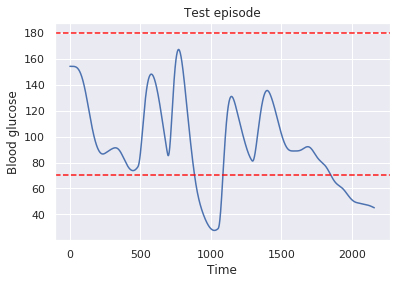

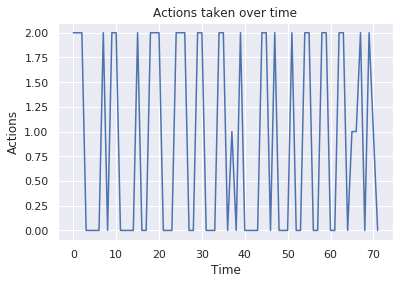

TIR: 76.48%


In [0]:
bg_hist_test, action_list_test = test_episode(model_local)

# Learning curve plot

In [0]:
def learning_curve(rewards):
  y = rewards
  w = np.ones(50)

  y_w = 2*y[0] - np.flip(y[0:50], 0)
  y_w = np.concatenate([y_w, np.asarray(y[:])])
  y_w = np.concatenate([y_w, 2*y[-1] - np.flip(y[-1-50:-1], 0)])

  y_smooth = np.convolve(y_w, w/sum(w))

  idx = int(np.floor(1.5*50))
  reward_smooth = y_smooth[idx:-1-idx-2]

  plt.figure()
  plt.plot(y)
  plt.plot(reward_smooth)
  plt.title("Learning curve")
  plt.xlabel("Episodes")
  plt.ylabel("Returns")
  plt.legend(["Learning curve", "Learning curve smoothed"], loc='best')

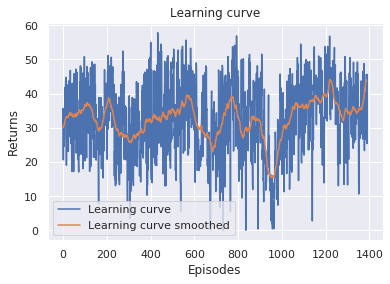

In [0]:
learning_curve(reward_list)

# Mean blood glucose history plot

In [0]:
def mean_bg_history(model):
  bg_list = []

  for i in range(100):
    done = False
    meals, meal_indicator = meal_generator()
    db.env.meals = meals
    db.env.meal_indicator = meal_indicator
            
    state = db.reset()

    while not done:
      action = model.choose_action(state, 0)
      state, reward, done, _ = db.step(action)
    
    bg_list.append(db.env.bg_history)

  mean_bg_min = np.mean(bg_list, 0)
  std_bg_min  = np.std(bg_list, 0)
  mean_bg_epi = np.mean(bg_list, 1)
  std_bg_epi  = np.std(bg_list, 1)

  low_bound = mean_bg_min - std_bg_min
  high_bound = mean_bg_min + std_bg_min

  bg_low  = 70
  bg_high = 180

  TBR = sum(mean_bg_min < bg_low)/len(mean_bg_min) * 100
  TAR = sum(mean_bg_min > bg_high)/len(mean_bg_min) * 100
  TIR = 100 - (TBR + TAR)

  plt.figure()
  plt.plot(mean_bg_min)
  plt.fill_between(np.linspace(0, 2160, 2160), low_bound, high_bound,
                   alpha=0.3, edgecolor='#1B2ACC', facecolor='#089FFF')
  plt.title('Mean blood glucose per minute')
  plt.xlabel('Time steps')
  plt.ylabel('Blood glucose')
  plt.axhline(y = bg_low, c='red', ls='--', alpha=0.9)
  plt.axhline(y = bg_high, c='red', ls='--', alpha=0.9)
  plt.show()

  print("TBR: {}%".format(round(TBR, 2)))
  print("TAR: {}%".format(round(TAR, 2)))
  print("TIR: {}%".format(round(TIR, 2)))

  return mean_bg_min, low_bound, high_bound, mean_bg_epi, std_bg_epi

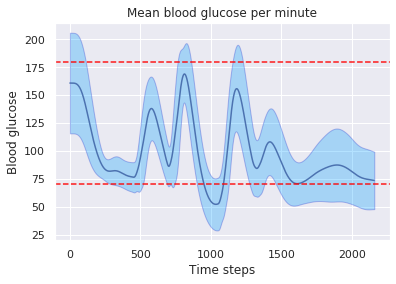

TBR: 6.39%
TAR: 0.0%
TIR: 93.61%


In [0]:
mean_bg_min, low_bound, high_bound, mean_bg_epi, std_bg_epi = mean_bg_history(model_local)

In [0]:
(mean_bg_epi.mean(), std_bg_epi.mean())

(98.41848851522869, 39.53371764328711)

# Time-in-range estimate

In [0]:
def time_in_range(model):
  bg_low  = 70
  bg_high = 180

  TBR_list = []
  TAR_list = []
  TIR_list = []

  for i in range(14):
    done = False
    meals, meal_indicator = meal_generator()
    db.env.meals          = meals
    db.env.meal_indicator = meal_indicator

    state = db.reset()

    while not done:
      action = model.choose_action(state, 0)
      state, reward, done, _ = db.step(action)
    
    bg_hist = db.env.bg_history

    TBR = sum(bg_hist < bg_low)/len(bg_hist) * 100
    TAR = sum(bg_hist > bg_high)/len(bg_hist) * 100
    TIR = 100 - (TBR + TAR)

    TBR_list.append(TBR)
    TAR_list.append(TAR)
    TIR_list.append(TIR)

  print("Mean TIR: {}%".format(round(np.mean(TIR_list), 2)))
  print("Mean TAR: {}%".format(round(np.mean(TAR_list), 2)))
  print("Mean TBR: {}%".format(round(np.mean(TBR_list), 2)))

In [0]:
time_in_range(model_local)  

Mean TIR: 67.52%
Mean TAR: 30.45%
Mean TBR: 2.04%


# **Save data**

In [0]:
import csv

    #Save test episode with actions
    np.savetxt("bg_hist_test.csv", bg_hist_test, delimiter=",")
    np.savetxt("actions_test.csv", action_list_test, delimiter=",")

    # Save all rewards
    np.savetxt("dqn_rewards.csv", reward_list, delimiter=",")

    # Save mean BG per minute and boundaries
    np.savetxt("mean_bg_min.csv", mean_bg_min, delimiter=",")
    np.savetxt("low_bound.csv", low_bound, delimiter=",")
    np.savetxt("high_bound.csv", high_bound, delimiter=",")